In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import fortitudo.tech as ft
import scipy.io as scio
import pypfopt as pfopt
from numba import njit
import time

In [25]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [46]:
start_date = '2006-01-01'
end_date = '2023-06-01'

In [22]:
A300 = pd.read_excel('A300_daily.xls').dropna()
A500 = pd.read_excel('A500_daily.xls').dropna()
SPX = pd.read_excel('SPX_daily.xls').dropna()
HSI = pd.read_excel('HSI_daily.xls').dropna()

AU9999 = pd.read_excel('AU9999_daily.xls').dropna()

indices = {'A300':A300, 'A500':A500, 'SPX':SPX, 'HSI':HSI, 'AU9999':AU9999}

# 清洗数据
for name, index in indices.items():
    index = index.dropna()
    index = index[(index['交易时间'] >= start_date) & (index['交易时间'] <= end_date)]
    index = index.reset_index(drop=True)
    indices[name] = index   

#同步时间序列，直接删除不同市场区域不匹配的交易时间
for index, row in indices['A300'].iterrows():
    if(indices['HSI']['交易时间'] == row['交易时间']).sum() == 0:
        indices['A300'].drop(index = index, inplace = True)
        indices['A500'].drop(index = index, inplace = True)
        indices['AU9999'].drop(index = index, inplace = True)
    if(indices['SPX']['交易时间'] == row['交易时间']).sum() == 0:
        if index in indices['A300'].index.values:
            indices['A300'].drop(index = index, inplace = True)
        if index in indices['A500'].index.values:
            indices['A500'].drop(index = index, inplace = True)
        if index in indices['AU9999'].index.values:
            indices['AU9999'].drop(index = index, inplace = True)

for index, row in indices['SPX'].iterrows():
    if(indices['HSI']['交易时间'] == row['交易时间']).sum() == 0:
        indices['SPX'].drop(index = index, inplace = True)
    if(indices['A300']['交易时间'] == row['交易时间']).sum() == 0:
        if index in indices['SPX'].index.values:
            indices['SPX'].drop(index = index, inplace = True)

for index, row in indices['HSI'].iterrows():
    if(indices['SPX']['交易时间'] == row['交易时间']).sum() == 0:
        indices['HSI'].drop(index = index, inplace = True)
    if(indices['A300']['交易时间'] == row['交易时间']).sum() == 0:
        if index in indices['HSI'].index.values:
            indices['HSI'].drop(index = index, inplace = True)

for name, index in indices.items():
    index.reset_index(drop=True, inplace=True)

In [29]:
SPX_VIX = pd.read_csv('SPX_VIX_daily.csv').dropna()
for i in range(SPX_VIX.shape[0]):    # conver data format
    SPX_VIX.loc[i, 'DATE'] = pd.Timestamp(time.strftime("%Y-%m-%d", time.strptime(SPX_VIX.loc[i, 'DATE'], "%m/%d/%Y")))

for index, row in SPX_VIX.iterrows():
    if (indices['A300']['交易时间'] == row['DATE']).sum() == 0:
        SPX_VIX.drop(index = index, inplace = True)
SPX_VIX.reset_index(drop=True, inplace=True)

for index, row in indices['A300'].iterrows():
    if (SPX_VIX['DATE'] == row['交易时间']).sum() == 0:
        print(row['交易时间'])
        indices['A300'].drop(index = index, inplace = True)
        indices['A500'].drop(index = index, inplace = True)
        indices['SPX'].drop(index = index, inplace = True)
        indices['HSI'].drop(index = index, inplace = True)
        indices['AU9999'].drop(index = index, inplace = True)

In [30]:
for name, index in indices.items():
    index.reset_index(drop=True, inplace=True)
SPX_VIX.reset_index(drop=True, inplace=True)

In [31]:
# 因为重新同步了市场时间，所以需要重新计算涨跌幅
for name, index in indices.items():
    for i in range(1,index.shape[0]): #第0天不算了
        index.loc[i,'涨跌'] = index['收盘价'][i] - index['收盘价'][i-1]
        index.loc[i,'涨跌幅%'] = index.loc[i,'涨跌'] / index.loc[i-1,'收盘价'] * 100

In [33]:
pnls = np.array([[0] * 4003])    # 把涨跌幅做成矩阵方便使用
names = []
for name, index in indices.items():
    names.append(name)
    pnls = np.r_[pnls, np.array(index['涨跌幅%']).reshape(1,-1)]
pnls = pd.DataFrame(pnls[1:].astype('float64').T,columns = names)
display(pnls)

,A300,A500,SPX,HSI,AU9999
0,1.947044,1.348631,0.367269,1.708223,3.489332
1,1.880119,1.261859,0.001571,0.467564,-0.231532
2,1.136447,1.043354,0.939944,0.480056,-0.783233
3,0.538128,1.472072,0.365631,1.322890,2.653315
4,0.297360,0.676191,-0.035655,0.144590,0.356024
...,...,...,...,...,...
3998,-1.382377,-0.770567,-0.731864,-1.622747,0.643498
3999,-0.222695,-0.293100,0.875769,-1.930380,-0.274021
4000,-0.331022,1.221071,1.306585,-0.806212,-0.864534
4001,-1.021692,-0.222823,-0.610864,-1.944043,1.318250


## 统计特征

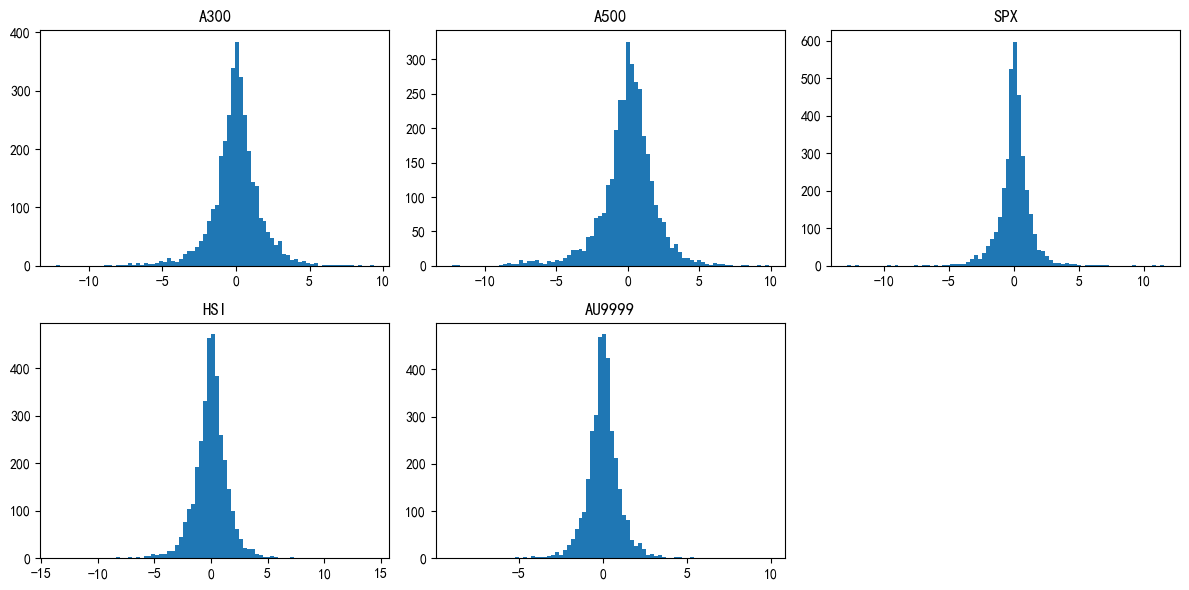

In [249]:
# 分布直方图

fig = plt.figure(figsize=(12, 6))
i = 1
for name, index in indices.items():
    ax = plt.subplot(2, 3, i)
    ax.set_title(name)
    plt.tight_layout()
    plt.hist(np.array(index['涨跌幅%']), bins=80)
    i += 1

In [250]:
# 计算期望与协方差

Mu = pnls.mean(axis = 0)
Sigma = pnls.cov()
display(np.round(Mu,2))
display(np.round(pnls.corr(), 2))   # 相关系数矩阵
display(np.round(Sigma, 2))  # 协方差矩阵

A300      0.01
A500      0.02
SPX       0.04
HSI       0.00
AU9999    0.03
dtype: float64

,A300,A500,SPX,HSI,AU9999
A300,1.00,0.88,0.13,0.56,0.05
A500,0.88,1.00,0.09,0.44,0.04
SPX,0.13,0.09,1.00,0.28,0.01
HSI,0.56,0.44,0.28,1.00,0.08
AU9999,0.05,0.04,0.01,0.08,1.00


,A300,A500,SPX,HSI,AU9999
A300,2.87,2.85,0.30,1.52,0.09
A500,2.85,3.67,0.25,1.36,0.09
SPX,0.30,0.25,1.85,0.60,0.02
HSI,1.52,1.36,0.60,2.55,0.14
AU9999,0.09,0.09,0.02,0.14,1.09


In [ ]:
# 正态性检验

alpha = 0.05
print("W正态性检验")
for i in range(pnls.shape[1]):
    if (scipy.stats.shapiro(pnls.values[:, i])[1] <= alpha):
        print(names[i], '非正态')
    else:
        print(names[i], '正态')

print("\nK-S正态性检验")
for i in range(pnls.shape[1]):
    if (scipy.stats.kstest(pnls.values[:, i], cdf='norm')[1] <= alpha):
        print(names[i], '非正态')
    else:
        print(names[i], '正态')

In [ ]:
# 分布图
# 蓝色直方图，深蓝色核密度函数，橙色正态密度函数

fig = plt.figure(figsize=(12, 6))
i = 0
for name, index in indices.items():
    ax = plt.subplot(2, 3, i + 1)
    ax.set_title(name)
    plt.tight_layout()
    pnl = np.array(index['涨跌幅%'])
    norm_x = np.linspace(pnl.min(), pnl.max(), 1000)
    norm_y = scipy.stats.norm.pdf(norm_x, Mu[i], np.sqrt(Sigma.values[i,i]))
    plt.plot(norm_x,norm_y,c="orange", label='Norm')
    sns.histplot(data = pnl, bins = 80, kde=True, ax = ax, element="step", stat="density", label='KDE')
    plt.legend()
    i += 1

## 熵池模型
熵池(Entropy Pooling, EP)模型通过相对熵(Relative Entropy, RE)来衡量分布之间的距离，最小化嵌入了观点和市场影响因素的后验分布和先验分布之间的RE距离来剔除多余观点，得到符合观点表述的最简后验分布。

## 解析解
正态先验总体的解析解，得到后验正态总体。

In [ ]:
def prior2posterior(mu, q, mu_q, sigma, g, sigma_g):
    """
    Analytical solution to the constrain
    X ~ (Mu, Sigma)
    E(QX) = Mu_Q
    Cov(GX) = Sigma_G
    
    minimize the KL divergence
    
    X ~ (Mu_tilda, Sigma_tilda)
    
    See the following paper for more details.

    Meucci, Attilio, Fully Flexible Views: Theory and Practice (August 8, 2008). 
    Fully Flexible Views: Theory and Practice, Risk, Vol. 21, No. 10, pp. 97-102, October 2008. 
    Available at SSRN: https://ssrn.com/abstract=1213325
    
    
    """
    mu_tilda = sigma * q.T * np.linalg.inv(q * sigma * q.T) * (mu_q - q * mu)
    tmp = np.linalg.inv(g * sigma * g.T)
    sigma_tilda = sigma + (sigma * g.T) * (tmp * sigma_g * tmp - tmp) * (g*sigma)
    return mu_tilda, sigma_tilda

In [ ]:
# 给定观点（随便设置的）
# 可将数值设置大（可能没有现实意义）一些以清晰看出图形变化

# 控制变量进行简单观点测试
# 发现即使只对一个量引入观点也会导致其他相关量变化
# 相关性越强变化越大
# Q = np.matrix([[1, 0, 0, 0, 0]])
# Mu_Q = np.array([1.1*Mu[0]+0.4]).reshape(-1, 1)  

# 复杂观点测试
Q = np.matrix([[1, 0, 0, 0, 0],
               [0, 1, 0, 0, 0],
               [0, 0, 1, -1, 0],
               [1, 0, 0, 0, 1]])
Mu_Q = np.array([Mu[0]-0.3,
                 Mu[1]+0.5,
                 0.9*Mu[2] - 1.5*Mu[3] - 0.2,
                 1.1*Mu[0] + 0.9*Mu[1] - 0.4]).reshape(-1, 1)   

G = np.eye(5)
Sigma_G = 1.1 * Sigma.values   # 调整协方差矩阵以引入波动率，也可以引入其他线性组合的协方差

Mu_tilda, Sigma_tilda = prior2posterior(Mu.values.reshape(-1,1), Q, Mu_Q, Sigma.values, G, Sigma_G)
Mu_tilda = np.array(Mu_tilda)

In [ ]:
# 分布图
# 蓝色先验分布，橙色后验分布
# 结果不知道为什么均值一直是0

fig = plt.figure(figsize=(12, 6))
for i, name in enumerate(names):
    ax = plt.subplot(2, 3, i + 1)
    ax.set_title(name)
    plt.tight_layout()
    
    prior_norm_x = np.linspace(Mu[i] - 3 * np.sqrt(Sigma.values[i,i]),
                         Mu[i] + 3 * np.sqrt(Sigma.values[i,i]), 1000)
    post_norm_x = np.linspace(Mu_tilda[i] - 3 * np.sqrt(Sigma_tilda[i,i]),
                         Mu_tilda[i] + 3 * np.sqrt(Sigma_tilda[i,i]), 1000)
    
    prior_norm_y = scipy.stats.norm.pdf(prior_norm_x, Mu[i], np.sqrt(Sigma.values[i,i]))
    post_norm_y = scipy.stats.norm.pdf(post_norm_x, Mu_tilda[i], np.sqrt(Sigma_tilda[i,i]))
    
    plt.plot(prior_norm_x,prior_norm_y,c="cornflowerblue", label = 'Prior')
    plt.axvline(x=Mu[i], linestyle='--',c="cornflowerblue")
    plt.plot(post_norm_x,post_norm_y,c="orange", label='Post')
    plt.axvline(x=Mu_tilda[i], linestyle='--', c="orange")
    plt.legend()

## 数值解1 (无法运行)
EP是通过minimize RE来获得市场后验分布，但是大部分情况下总体的分布并不能被看作正态的，此时计算EP的解析解是困难的，因此需要数值解法来得到更具应用普遍性的结果

最优化任务：$argmin_{f} KL(f, g)$, g s.t. constraints，constraints为观点

也就是在函数空间内搜索一个与先验分布最相似但是满足constraints的分布

数值的方法是通过建造一个Panel $V$来表示分布

$V$ 其实就是讲市场的信息（回报率，价格，因子等等），通过观点function $g_k(...)$ 映射得来

$V_{j,k} = g_k(X_{j,1}, ..., X_{j,N})$

对于一个这样的panel, 可以形成一个JX1的向量，用来代表每个scenario下的概率，$p$  
而后验分布$\widetilde{p}$，则是我们需要通过优化得到的，用它来minimize KL-divergence

其中k代表k个观点，而j代表的是simultaion的数量  
而RE距离的连续形式可以被改成离散的形式
$E(\widetilde{p}, p) = \sum_{j=1}^J \widetilde{p}_j[ln(\widetilde{p}_j) - ln(p_j)]$

但是在Meucci的第二篇文章Fully Exterme Views中，没有采用Monte Carolo Simulation去获得V panel
而是采用类似于Grid Search的方式
作者这里使用的是Hermite Polynomial的零点作为grid

这里计算直接使用了eqaully spaced的interval

In [ ]:
def kde_scipy(x, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = scipy.stats.gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde

def kernelbw(x):
    # Bandwith 计算
    n = len(x)
    prop = 1.0
    sig = np.std(x)
    iqrSig = 0.7413 * scipy.stats.iqr(x)
    if iqrSig == 0:
        iqrSig = sig
    bw = prop * min(sig, iqrSig) * n ** (-1/(4+1))
    return bw

def kernelpdf(x, xi, wi):
    n = len(xi)
    bw = kernelbw(xi)
    
    p = np.zeros(len(x))
    for i in range(n):
        p = p + wi[i] * scipy.stats.norm.pdf(x, loc=xi[i], scale = bw);
    return p

def kernelcdf(x, xi, wi):
    np.seterr(divide = 'ignore')    # 关闭计算警告
    n = len(xi)
    bw = kernelbw(xi)
    if type(x) is not np.ndarray:
        p = np.zeros(1)
        for i in range(n):
            p = p + np.exp(np.log(wi[i]) + np.log(scipy.stats.norm.cdf(x, loc=xi[i], scale=bw)))
        return p[0]
    else:
        p = np.zeros(len(x))
        for i in range(n):
            p = p + np.exp(np.log(wi[i]) + np.log(scipy.stats.norm.cdf(x, loc=xi[i], scale=bw)))
        return p
    np.seterr(divide = 'warn')    # 还原计算警告

def kernelinv(p, xi, wi):
    import collections.abc
    
    def helper(x, xi, wi, p):
        f = kernelcdf(x, xi, wi) - p
        return f

    if not isinstance(p, collections.abc.Iterable):
        sortp = p
        x = scipy.optimize.newton(helper, x0 = 1, args=(xi, wi, sortp), maxiter=50)
        return x
    elif len(p) < 10:
        x = np.zeros(len(p))
        tmp = scipy.optimize.newton(helper, x0 = 1, args=(xi, wi, p[0]), maxiter=50)
        for i in range(len(p)):
            x[i] = tmp
        return x
    else:
        sortp = np.sort(p)
        x_min = scipy.optimize.newton(helper, x0 = 1, args=(xi, wi, sortp[0]), maxiter=50)
        x_max = scipy.optimize.newton(helper, x0 = 1, args=(xi, wi, sortp[len(sortp)-1]), maxiter=50)
    
        # mesh for x values
        x_ = np.linspace(x_min - 0.1 * abs(x_min), x_max + 0.1 * abs(x_max), 500)

        # evaluates the mesh on these values
        y_ = kernelcdf(x_, xi, wi);
        x = np.interp(p, y_, x_)
        return x
    
def subIntervals(x):
    n = len(X)
    xMesh = np.empty(n+1)
    xMesh[0] = X[0]
    xMesh[n] = X[n-1]
    xMesh[1:n] = X[1:] - 0.5 * (X[1:] - X[0:n-1])

    xUB = xMesh[1:] - 2.2e-308
    xLB = xMesh[0: n] 
    return xUB, xLB
def intergrateSubIntervals(x, cdf):
    xUB, xLB = subIntervals(X)
    p = (cdf(xUB) - cdf(xLB)) 
    return p

def normalizeProb(p):
    tol = 1e-20
    tmp = p
    tmp[tmp<tol] = tol
    return tmp / sum(tmp)

In [ ]:
# 这里以沪深300指数为例
xi = np.array(indices['A500']['涨跌幅%'])
n = xi.shape[0]

# bandwith
bw = kernelbw(xi)

# weights
lamb = np.log(2) / (n / 2);
wi = np.exp(-lamb * np.array(range(n)))
wi = np.array(list(reversed(wi))) / sum(wi)

mu = np.mean(xi)
pdf = lambda x: kernelpdf(x, xi, wi)
cdf = lambda x: kernelcdf(x, xi, wi)
inv = lambda x: kernelinv(x, xi, wi)
VaR95 = inv(0.05)

J = 10000
tmp = np.linspace(0, 1, 1000)
epsilon = 1e-10
Lower = inv(epsilon)
Upper = inv(1 - epsilon)
# X = Lower + tmp * (Upper - Lower)

delta = (Upper - Lower) / J
X = np.array([Lower + (2*j - 1) / 2 * delta for j in range(1, J+1)])

p = intergrateSubIntervals(X, cdf)
# p = normalizeProb(p)

In [ ]:
def nestedfunU(v):
    global lnp, Aeq, Beq
    v = v.reshape((v.shape[0], 1))

    lnx = lnp - 1 - Aeq.T * v
    
    x = np.exp(lnx)
    L = x.T * (lnx - lnp + Aeq.T * v) - Beq.T * v

    return -L[0, 0]   

In [ ]:
# Constraints

view_mu = np.mean(xi) + 1     # 收益率和波动都增加很多的情况
view_variance = np.var(xi) + 5
Aeq = np.matrix([np.ones(J), X**2, X])
Beq = np.matrix([1, view_variance, view_mu]).T

lnp = np.matrix(np.log(p)).T 

x0 = [np.random.random() for _ in range(3)]
res = scipy.optimize.minimize(nestedfunU, x0, method='BFGS', tol=1e-10)
v = res.x
v = v.reshape((v.shape[0], 1))
lnp_ = lnp - 1 - Aeq.T * v
p_ = np.array(np.exp(lnp_)).reshape(lnp_.shape[0])

prior_mean = np.dot(X, p)
posterior_mean = np.dot(X, p_)
posterior_var = np.dot(X**2, p_)

print('Mean: Prior %.5f, Post %.5f' % (np.mean(xi), posterior_mean))

print('Var: Prior %.5f, Post %.5f' % (np.var(xi), posterior_var))

plt.plot(X, p, label = 'prior', c="cornflowerblue")
plt.plot(X, p_, label = 'post', c="orange")
plt.axvline(x=np.mean(xi), linestyle='--',c="cornflowerblue")
plt.axvline(x=posterior_mean, linestyle='--',c="orange")

plt.legend()

## 数值解2
这里直接使用 fortitudo.tech 库

In [ ]:
R_df = pd.DataFrame(data=pnls[0:2000], columns=names)
instrument_names = R_df.columns

print('原始数据')
# Print prior P&L stats
stats_prior = ft.simulation_moments(R_df)
display(np.round(stats_prior, 2))

corr_prior = ft.correlation_matrix(R_df)
display(np.round(corr_prior, 2))

### 先验情景分布为均匀分布的情况
离散情景先验分布可以认为是均等的，因此一般采用均匀分布即可。

In [ ]:
R = R_df.values
S = R.shape[0]
p = np.ones((S, 1)) / S    # 均匀分布
means_prior = p.T @ R      # 先验均值
vols_prior = np.sqrt(p.T @ (R - means_prior)**2)    # 先验标准差和样本标准差差距很大


A300_A500_mean = (R[:, 0]-R[:, 1])[np.newaxis, :]   # A300和A500均值之差
A300_mean = (R[:, 0])[np.newaxis, :]
A500_mean = (R[:, 1])[np.newaxis, :]
SPX_mean = R[:, 3][np.newaxis, :]
HSI_kurt = (((R[:, 2] - means_prior[:, 2]) / vols_prior[:, 2])**4)[np.newaxis, :]
A500_kurt = (((R[:, 1] - means_prior[:, 1]) / vols_prior[:, 1])**4)[np.newaxis, :]

A = np.vstack((np.ones((1, S)), A300_A500_mean, A500_kurt))   # 等式约束设置
b = np.vstack(([1.0], [0.02], [7.0]))                # 第一项约束为离散分布和为1
G = np.vstack((SPX_mean, -HSI_kurt, -A300_mean, -A500_mean))
h = np.vstack(([0.01], [-12], [-0.03], [-0.05]))

q = ft.entropy_pooling(p, A, b, G, h)
relative_entropy = q.T @ (np.log(q) - np.log(p))
effective_number_scenarios = np.exp(-relative_entropy)

print(f'ENS = {np.round(effective_number_scenarios[0, 0] * 100, 2)}%.')
print(f'RE = {np.round(relative_entropy[0, 0] * 100, 2)}%.')

stats_post = ft.simulation_moments(R_df, q)
display(np.round(stats_post, 2))

corr_post = ft.correlation_matrix(R_df, q)
display(np.round(corr_post, 2))

In [ ]:
fig = plt.figure(figsize=(5, 3))
plt.ylim((q.min(), q.max()))
plt.bar(x = np.arange(q.shape[0]), height = q.reshape(-1), width=1, alpha=0.5, label='Post')
plt.bar(x = np.arange(p.shape[0]), height = p.reshape(-1), width=1, alpha=0.5, label='Prior')
plt.xticks([])
plt.legend()

## 技术指标

### RSI

In [7]:
prices = []
for name, index in indices.items():
    prices.append(index['收盘价'])
prices = np.array(prices)

price_moves = []
for i in range(prices.shape[0]):
    price_moves.append([0])
    for j in range(1, prices.shape[1]):
        price_moves[i].append(prices[i][j] - prices[i][j - 1])
price_moves = np.array(price_moves)

In [8]:
def RSI(price, price_move, period = 12):
    rsi = np.array([0] * period)
    avg_gain = np.array([0] * period)
    avg_loss = np.array([0] * period)

    sub_move = price_move[1: period + 1]
    _avg_gain = np.sum(sub_move[sub_move >= 0])/period
    _avg_loss = np.sum(-sub_move[sub_move < 0])/period
    avg_gain = np.append(avg_gain, _avg_gain)
    avg_loss = np.append(avg_loss, _avg_loss)
    rsi = np.append(rsi, _avg_gain/(_avg_gain + _avg_loss) * 100)
    
    for i in range(period + 1, price.shape[0]):
        _avg_gain = (avg_gain[i - 1] * (period - 1) + max(price_move[i], 0)) / period
        _avg_loss = (avg_loss[i - 1] * (period - 1) + max(-price_move[i], 0)) / period
        avg_gain = np.append(avg_gain, _avg_gain)
        avg_loss = np.append(avg_loss, _avg_loss)
        rsi = np.append(rsi, _avg_gain/(_avg_gain + _avg_loss) * 100)
    return rsi

In [9]:
R1 =  RSI(prices[0], price_moves[0], period = 10)
R2 =  RSI(prices[0], price_moves[0], period = 15)
R3 =  RSI(prices[0], price_moves[0], period = 20)

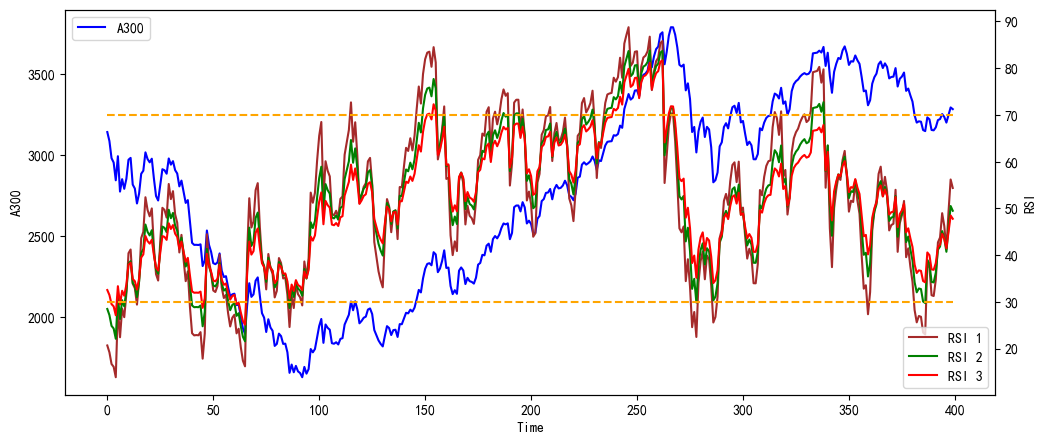

In [10]:
fig = plt.figure(figsize = (12,5))
begin = 100
end = 500
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel('A300')
ax.plot(np.arange(prices[0][begin:end].shape[0]), prices[0][begin:end],color = 'blue', label = 'A300')
ax2 = ax.twinx()
ax2.set_ylabel('RSI')
ax2.plot(np.arange(R1[begin:end].shape[0]), R1[begin:end], color = 'brown', label = 'RSI 1')
ax2.plot(np.arange(R2[begin:end].shape[0]), R2[begin:end], color = 'green', label = 'RSI 2')
ax2.plot(np.arange(R3[begin:end].shape[0]), R3[begin:end], color = 'red', label = 'RSI 3')
ax2.plot(np.arange(prices[0][begin:end].shape[0]), [70] * prices[0][begin:end].shape[0], '--', color = 'orange')
ax2.plot(np.arange(prices[0][begin:end].shape[0]), [30] * prices[0][begin:end].shape[0], '--', color = 'orange')
ax.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')

### 动量

In [218]:
def momentum(prices, day_ago):
    diff = np.c_[prices[:, :day_ago], prices][:,:-day_ago]
    return (prices - diff) / diff

In [219]:
mtm1 = momentum(prices, 20)

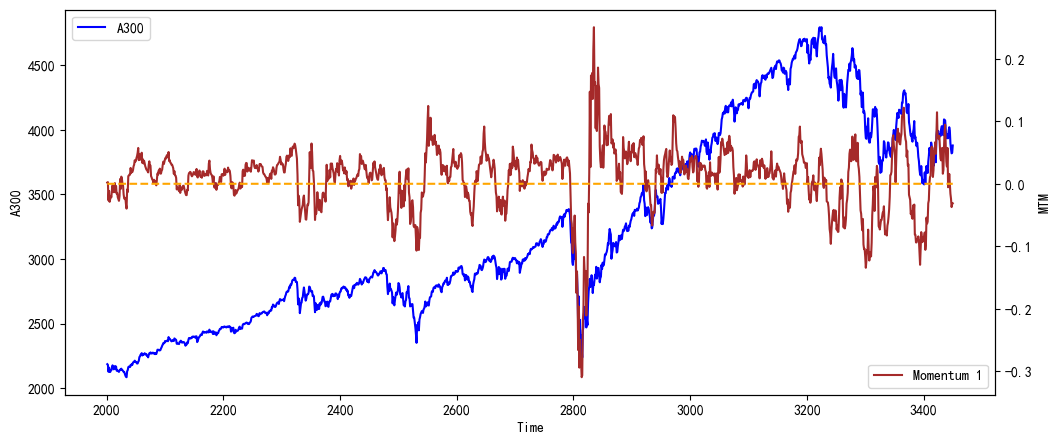

In [220]:
fig = plt.figure(figsize = (12,5))
begin = 2001
end = 3451
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel('A300')
ax.plot(np.arange(begin, end), prices[2][begin:end],color = 'blue', label = 'A300')
ax2 = ax.twinx()
ax2.set_ylabel('MTM')
ax2.plot(np.arange(begin, end), mtm1[2][begin:end], color = 'brown', label = 'Momentum 1')
ax2.plot(np.arange(begin, end), [0] * (end - begin), '--', color = 'orange')
ax.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')

## Monte Carlo 模拟

In [14]:
### 测试代码
sim_times = 100
all_choice = np.arange(R.shape[0])
sim_series = []
end_time = 1028
for i in range(sim_times):
    now_price = np.array([1,1,1,1,1],dtype=np.float64)
    sim = []
    for t in range(1, end_time):
        scene = np.random.choice(all_choice, p = p.ravel())
        drive = R[scene]
        now_price = now_price * (1 + drive * 0.01)
        sim.append(now_price)
    sim = np.array(sim).T
    sim_series.append(sim)
sim_series = np.array(sim_series)

NameError: name 'R' is not defined

In [ ]:
win = 0
fail = 0
A300_endPrice = np.array([], dtype=np.float64)
for i in range(sim_times):
    A300_endPrice = np.append(A300_endPrice, sim_series[i][0][-1])
win = (A300_endPrice > 1).sum()
fail = (A300_endPrice < 1).sum()
    
print(f'Win rate: {win/(win+fail)}')
print(f'Exp: {np.mean(A300_endPrice)}')
print(f'Var: {np.cov(A300_endPrice)}')

fig = plt.figure(figsize=(12,5))
period = np.arange(1,end_time)
for i in range(100):
    plt.plot(period, sim_series[i][0])

## Mean-Variance P&L最优化

In [ ]:
sim_times = 20000
all_choice = np.arange(R.shape[0])
sim_series = []
end_time = 20
for i in range(sim_times):
    now_price = np.array([1,1,1,1,1],dtype=np.float64)
    sim = []
    sim.append(now_price)
    for t in range(1, end_time):
        scene = np.random.choice(all_choice, p = p.ravel())
        drive = R[scene]
        now_price = now_price * (1 + drive * 0.01)
        sim.append(now_price)
    sim = np.array(sim).T
    sim_series.append(sim)
sim_series = np.array(sim_series)

In [ ]:
sim_series.shape

In [ ]:
sim_last = np.c_[sim_series[:,:,-1],(np.ones(sim_series.shape[0]) / 1.04).reshape(-1,1)]
sim_mean = np.power(np.mean(sim_last, axis=0), 250/end_time) - 1
sim_cov = np.cov(sim_last.T) * 250 / end_time
display(sim_mean)
display(sim_cov)

In [ ]:
names.append('Cash')

In [ ]:
opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
opt1_port = np.array(list(opt1.max_sharpe().values()))  * 100
display(pd.DataFrame(np.round(opt1_port,2), index = names, columns = ['Proportion']))
print('Total:', opt1_port.sum())
print(opt1.portfolio_performance(verbose=True))

In [ ]:
opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
opt1_port = np.array(list(opt1.efficient_return(0.08).values()))  * 100
display(pd.DataFrame(np.round(opt1_port,2), index = names, columns = ['Proportion']))
print('Total:', opt1_port[:-1].sum())
opt1.portfolio_performance(verbose=True)

### 蒙特卡洛模拟加速

In [8]:
@njit    #numba加速，需要明确定义数据类型
def price_MonteCarlo(sim_times:int, n_ptf:int, R:np.ndarray, p:np.ndarray) -> np.ndarray:
    def rand_choice_nb(arr:np.ndarray, prob:np.ndarray) -> np.ndarray:
        """
        :param arr: A 1D numpy array of values to sample from.
        :param prob: A 1D numpy array of probabilities for the given samples.
        :return: A random sample from the given array with a given probability.
        """
        return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

    all_choice = np.arange(R.shape[0])
    
    sim_end_time = 20
    sim_series = np.zeros((sim_times, n_ptf))
    for i in range(sim_times):
        now_price = np.ones(n_ptf,dtype=np.float64)
        for t in range(1, sim_end_time):
            #scene = np.random.choice(all_choice, p = p.ravel()) # p parameter is not supported
            scene = rand_choice_nb(all_choice, p)
            drive = R[scene]
            now_price = now_price * (1 + drive * 0.01)
        sim_series[i, :] = now_price
    return sim_series

### 加入技术指标

In [34]:
def RSI(price, price_move, period = 12):
    rsi = np.array([0] * period)
    avg_gain = np.array([0] * period)
    avg_loss = np.array([0] * period)

    sub_move = price_move[1: period + 1]
    _avg_gain = np.sum(sub_move[sub_move >= 0])/period
    _avg_loss = np.sum(-sub_move[sub_move < 0])/period
    avg_gain = np.append(avg_gain, _avg_gain)
    avg_loss = np.append(avg_loss, _avg_loss)
    rsi = np.append(rsi, _avg_gain/(_avg_gain + _avg_loss) * 100)
    
    for i in range(period + 1, price.shape[0]):
        _avg_gain = (avg_gain[i - 1] * (period - 1) + max(price_move[i], 0)) / period
        _avg_loss = (avg_loss[i - 1] * (period - 1) + max(-price_move[i], 0)) / period
        avg_gain = np.append(avg_gain, _avg_gain)
        avg_loss = np.append(avg_loss, _avg_loss)
        rsi = np.append(rsi, _avg_gain/(_avg_gain + _avg_loss) * 100)
    return rsi

def momentum(prices, day_ago):
    diff = np.c_[prices[:, :day_ago], prices][:,:-day_ago]
    return (prices - diff) / diff

In [35]:
prices = []
for name, index in indices.items():
    prices.append(index['收盘价'])
prices = np.array(prices)

price_moves = []
for i in range(prices.shape[0]):
    price_moves.append([0])
    for j in range(1, prices.shape[1]):
        price_moves[i].append(prices[i][j] - prices[i][j - 1])
price_moves = np.array(price_moves)

In [37]:
begin_time = 1001
end_time = 4001-10
adj_period = 20
n_ptf = 5    # Portfolio number (no cash)

In [38]:
RSIs = []
for i in range(5):
    _RSI =  RSI(prices[i], price_moves[i], period = 20)
    RSIs.append(_RSI)
RSIs = np.array(RSIs)
RSIs

array([[ 0.        ,  0.        ,  0.        , ..., 36.10556573,
        33.7315737 , 34.69117014],
       [ 0.        ,  0.        ,  0.        , ..., 41.26447511,
        40.5581119 , 40.84679633],
       [ 0.        ,  0.        ,  0.        , ..., 57.96174868,
        55.61783291, 58.45340101],
       [ 0.        ,  0.        ,  0.        , ..., 35.17003393,
        32.3131573 , 32.18102034],
       [ 0.        ,  0.        ,  0.        , ..., 50.26263137,
        55.63710836, 55.21838974]])

In [39]:
MTMs = momentum(prices, 14)

In [40]:
names = ['A300', 'A500', 'SPX', 'HSI', 'AU9999']
R_df = pd.DataFrame(data=pnls[0:begin_time], columns=names)
instrument_names = R_df.columns

print('原始数据')
# Print prior P&L stats
stats_prior = ft.simulation_moments(R_df)
display(stats_prior)

原始数据


,Mean,Volatility,Skewness,Kurtosis
A300,0.138850,2.356785,-0.399385,5.135922
A500,0.192342,2.635368,-0.689827,4.944482
SPX,0.005157,1.697755,-0.233553,13.345621
HSI,0.053644,2.181580,0.114178,10.753213
AU9999,0.078704,1.425187,0.076089,7.965857


In [73]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([0,0,0,0,0,100.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - 20])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[time-1000:time], columns=names)
    R = R_df.values
    
    S = R.shape[0]
    stats_prior = ft.simulation_moments(R_df)
    maxRSI = np.max(RSIs[:,time-adj_period:time],axis=1)
    minRSI = np.min(RSIs[:,time-adj_period:time],axis=1)
    view_mean = np.zeros(n_ptf)
    for i in range(n_ptf):
        if maxRSI[i] >= 70:
            view_mean[i] -= 0.008
        if minRSI[i] <= 30:
            view_mean[i] += 0.005
    view_mean = stats_prior['Mean'] +view_mean
    
    p = (np.ones((S, 1),dtype=np.float64) / S)    # Prior distribution
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    b = np.append(np.array(1.0,dtype=np.float64), view_mean).reshape(-1,1)
    q1 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    view_mean = np.zeros(n_ptf)
    meanMTM = np.average(MTMs[:,time-adj_period:time], axis=1,weights = np.arange(1,2,0.05))
    for i in range(n_ptf):
        if 0.2 > meanMTM[i] > 0.1:
            view_mean += 0.004
        elif -0.2< meanMTM[i] < -0.1:
            view_mean -= 0.006
    view_mean = stats_prior['Mean'] +view_mean
    
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    b = np.append(np.array(1.0,dtype=np.float64), view_mean).reshape(-1,1)
    q2 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    q = q1 * 0.5 + q2 * 0.5
    q /= q.sum() # 缩放一下因为误差导致概率和不为1
    
    sim_end_time = 20
    sim_series = price_MonteCarlo(20000, n_ptf, R,q)
    sim_last = np.c_[sim_series,np.power((np.ones(sim_series.shape[0]) / (1+risk_free)), sim_end_time/250).reshape(-1,1)]
    sim_mean = np.power(np.mean(sim_last, axis=0), 250/sim_end_time) - 1
    sim_cov = np.cov(sim_last.T) * 250 / sim_end_time
    
#     try:
#         opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
#         _opt1_port = np.array(list(opt1.efficient_return(0.07).values())) * 100
#     except:
    if sim_mean.max() < risk_free:
        _opt1_port = pd.DataFrame([.0,.0,.0,.0,.0,100.], index = [*names, 'Cash'], columns = [time])
    else:
        opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
        _opt1_port = np.array(list(opt1.max_sharpe(risk_free_rate=risk_free).values()))  * 100
        _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)
    opt1.portfolio_performance(verbose=True)

1001
Expected annual return: 40.1%
Annual volatility: 24.6%
Sharpe Ratio: 1.55
1021
Expected annual return: 35.8%
Annual volatility: 23.9%
Sharpe Ratio: 1.42
1041
Expected annual return: 33.3%
Annual volatility: 23.8%
Sharpe Ratio: 1.31
1061
Expected annual return: 35.3%
Annual volatility: 24.9%
Sharpe Ratio: 1.33
1081
Expected annual return: 27.7%
Annual volatility: 23.4%
Sharpe Ratio: 1.10
1101
Expected annual return: 30.3%
Annual volatility: 21.6%
Sharpe Ratio: 1.31
1121
Expected annual return: 27.4%
Annual volatility: 23.0%
Sharpe Ratio: 1.10
1141
Expected annual return: 31.3%
Annual volatility: 21.8%
Sharpe Ratio: 1.35
1161
Expected annual return: 29.0%
Annual volatility: 20.0%
Sharpe Ratio: 1.35
1181
Expected annual return: 27.4%
Annual volatility: 20.1%
Sharpe Ratio: 1.27
1201
Expected annual return: 29.0%
Annual volatility: 20.9%
Sharpe Ratio: 1.29
1221
Expected annual return: 25.9%
Annual volatility: 19.7%
Sharpe Ratio: 1.22
1241
Expected annual return: 22.0%
Annual volatility

Expected annual return: 6.6%
Annual volatility: 10.1%
Sharpe Ratio: 0.46
3101
Expected annual return: 7.8%
Annual volatility: 8.5%
Sharpe Ratio: 0.68
3121
Expected annual return: 9.2%
Annual volatility: 8.5%
Sharpe Ratio: 0.85
3141
Expected annual return: 9.3%
Annual volatility: 8.8%
Sharpe Ratio: 0.84
3161
Expected annual return: 9.2%
Annual volatility: 8.8%
Sharpe Ratio: 0.82
3181
Expected annual return: 10.5%
Annual volatility: 8.8%
Sharpe Ratio: 0.96
3201
Expected annual return: 10.8%
Annual volatility: 8.5%
Sharpe Ratio: 1.03
3221
Expected annual return: 10.6%
Annual volatility: 8.1%
Sharpe Ratio: 1.07
3241
Expected annual return: 10.7%
Annual volatility: 7.8%
Sharpe Ratio: 1.12
3261
Expected annual return: 10.3%
Annual volatility: 8.1%
Sharpe Ratio: 1.03
3281
Expected annual return: 11.9%
Annual volatility: 9.9%
Sharpe Ratio: 1.00
3301
Expected annual return: 11.9%
Annual volatility: 9.5%
Sharpe Ratio: 1.04
3321
Expected annual return: 12.3%
Annual volatility: 9.4%
Sharpe Ratio: 

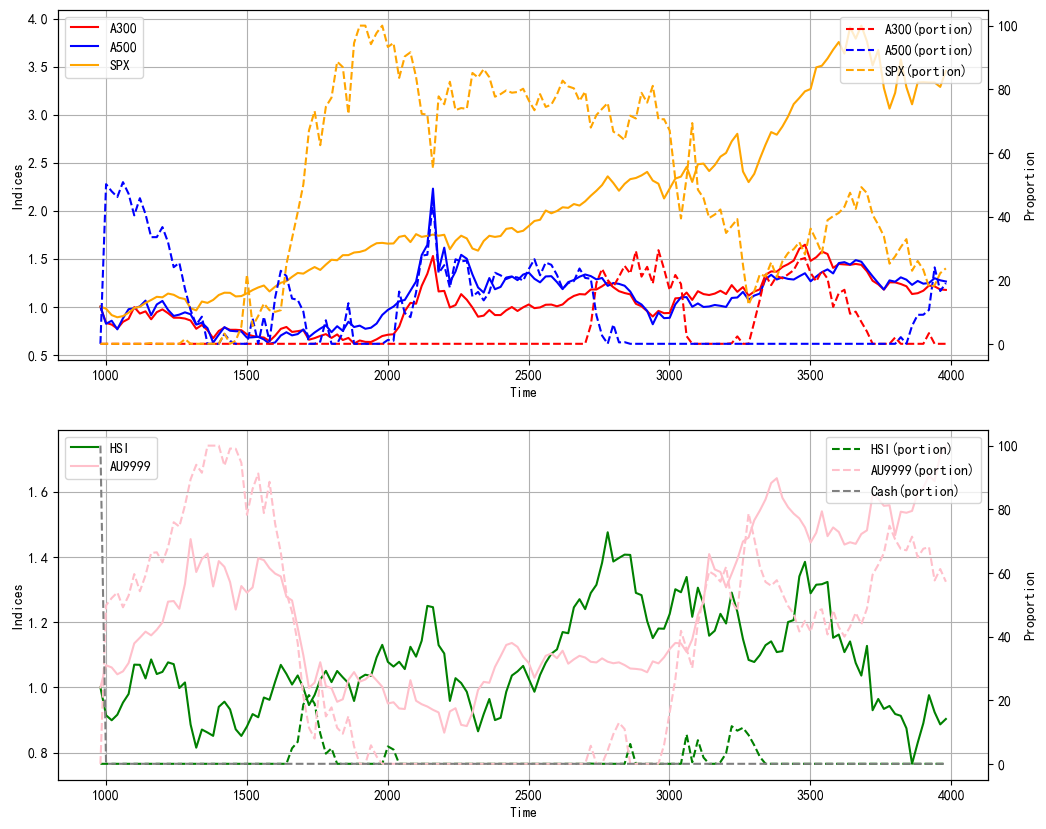

In [74]:
fig = plt.figure(figsize = (12,10))

time_series = np.arange(begin_time-adj_period, end_time+1,adj_period)
port_series = opt1_port
norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T
      
color = ['red', 'blue', 'orange', 'green', 'pink', 'grey']
    
ax = fig.add_subplot(211)
for i in range(3):
    ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
ax.set_xlabel('Time')
ax.set_ylabel('Indices')
ax.legend(loc = 'upper left')

ax2 = ax.twinx()
for i in range(3):
    ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
ax2.set_ylabel('Proportion')
ax2.legend(loc = 'upper right')

ax.grid()

ax = fig.add_subplot(212)
for i in range(3,n_ptf):
    ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
ax.set_xlabel('Time')
ax.set_ylabel('Indices')
ax.legend(loc = 'upper left')

ax2 = ax.twinx()
for i in range(3,n_ptf + 1):
    ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
ax2.set_ylabel('Proportion')
ax2.legend(loc = 'upper right')

ax.grid()

Start Date: 2010-05-12
End Date: 2023-05-11
Yearly Earning: 6.9%


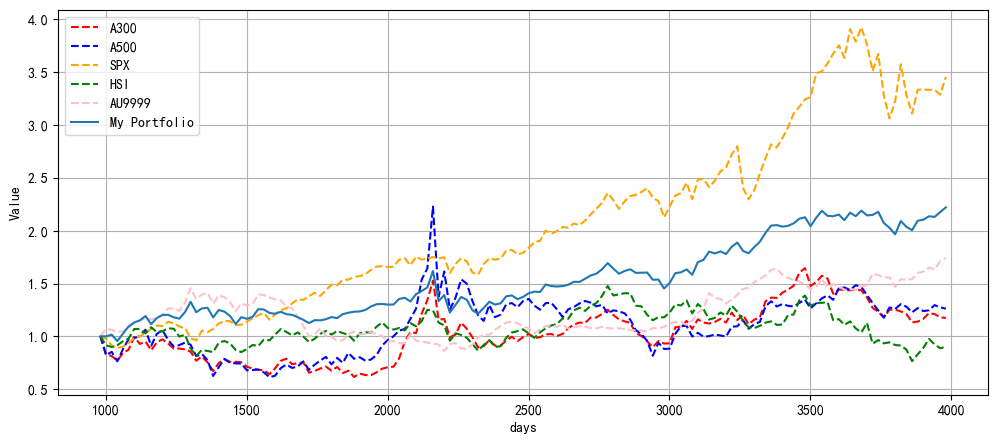

In [75]:
norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T

portfo = np.array([.0,.0,.0,.0,.0,1])
value_series = []
for time in range(begin_time - 20, end_time+1, adj_period):
    # 简单起见，不考虑手续费，先把所有东西卖了然后再买入
    prices_now = norm_prices[:,(time - (begin_time - adj_period))//adj_period]
    for i in range(n_ptf):
        portfo[n_ptf] += portfo[i] * prices_now[i]
        portfo[i] = .0
    ptf_portion = opt1_port.loc[:,time]
    value_series.append(portfo[n_ptf])
    
    for i in range(n_ptf):
        portfo[i] += portfo[n_ptf] * ptf_portion[i] *0.01 / prices_now[i]
    portfo[n_ptf] -= ptf_portion[:n_ptf].sum() * 0.01 * portfo[n_ptf]

fig = plt.figure(figsize=(12,5))
    
time_series = np.arange(begin_time-20, end_time+1,20)
plt.ticklabel_format(style='plain')
plt.xlabel('days')
plt.ylabel('Value')
for i in range(5):
    plt.plot(time_series, norm_prices[i,:], '--', label = names[i], color = color[i])
plt.plot(time_series, value_series, label='My Portfolio')
plt.legend()
plt.grid()
print('Start Date:', str(SPX_VIX.loc[begin_time, 'DATE'])[:10])
print('End Date:', str(SPX_VIX.loc[end_time, 'DATE'])[:10])
print(f'Yearly Earning: {np.round((value_series[-1]**(1/((end_time-begin_time)/250)) - 1) * 100,2)}%')

### VIX指数做波动率预测

In [76]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([0,0,0,0,0,100.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - adj_period])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[time-1000:time], columns=names)
    R = R_df.values
    
    S = R.shape[0]
    stats_prior = ft.simulation_moments(R_df)
    maxRSI = np.max(RSIs[:,time-adj_period:time],axis=1)
    minRSI = np.min(RSIs[:,time-adj_period:time],axis=1)
    view_mean = np.zeros(n_ptf)
    for i in range(n_ptf):
        if maxRSI[i] >= 70:
            view_mean[i] -= 0.008
        if minRSI[i] <= 30:
            view_mean[i] += 0.005
    view_mean = stats_prior['Mean'] +view_mean
    
    p = (np.ones((S, 1),dtype=np.float64) / S)    # Prior distribution
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    A = np.vstack((A, (R[:, 2] - stats_prior['Mean']['SPX']) ** 2))    # volatility
    b = np.append(np.array(1.0,dtype=np.float64), view_mean)
    b = np.append(b,1/252* (SPX_VIX.loc[time, 'CLOSE']) ** 2) # volatility
    b = b.reshape(-1,1)
    q1 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    view_mean = np.zeros(n_ptf)
    meanMTM = np.average(MTMs[:,time-adj_period:time], axis=1,weights = np.arange(1,2,0.05))
    for i in range(n_ptf):
        if 0.2 > meanMTM[i] > 0.1:
            view_mean += 0.004
        elif -0.2< meanMTM[i] < -0.1:
            view_mean -= 0.006
    view_mean = stats_prior['Mean'] +view_mean
    
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    A = np.vstack((A, (R[:, 2] - stats_prior['Mean']['SPX']) ** 2))    # volatility
    b = np.append(np.array(1.0,dtype=np.float64), view_mean)
    b = np.append(b,1/252* (SPX_VIX.loc[time, 'CLOSE']) ** 2) # volatility
    b = b.reshape(-1,1)
    q2 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    q = q1 * 0.5 + q2 * 0.5
    q /= q.sum() # 缩放一下因为误差导致概率和不为1
    
    sim_end_time = 20
    sim_series = price_MonteCarlo(20000, n_ptf, R,q)
    sim_last = np.c_[sim_series,np.power((np.ones(sim_series.shape[0]) / (1+risk_free)), sim_end_time/250).reshape(-1,1)]
    sim_mean = np.power(np.mean(sim_last, axis=0), 250/sim_end_time) - 1
    sim_cov = np.cov(sim_last.T) * 250 / sim_end_time
    
#     try:
#         opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
#         _opt1_port = np.array(list(opt1.efficient_return(0.07).values())) * 100
#     except:
    if sim_mean.max() < risk_free:
        _opt1_port = pd.DataFrame([.0,.0,.0,.0,.0,100.], index = [*names, 'Cash'], columns = [time])
    else:
        opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
        _opt1_port = np.array(list(opt1.max_sharpe(risk_free_rate=risk_free).values()))  * 100
        _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)
    opt1.portfolio_performance(verbose=True)

1001
Expected annual return: 37.0%
Annual volatility: 23.9%
Sharpe Ratio: 1.46
1021
Expected annual return: 37.5%
Annual volatility: 24.9%
Sharpe Ratio: 1.42
1041
Expected annual return: 33.8%
Annual volatility: 23.2%
Sharpe Ratio: 1.37
1061
Expected annual return: 33.1%
Annual volatility: 24.6%
Sharpe Ratio: 1.27
1081
Expected annual return: 29.3%
Annual volatility: 23.8%
Sharpe Ratio: 1.15
1101
Expected annual return: 27.5%
Annual volatility: 20.0%
Sharpe Ratio: 1.28
1121
Expected annual return: 28.5%
Annual volatility: 21.1%
Sharpe Ratio: 1.26
1141
Expected annual return: 29.4%
Annual volatility: 19.7%
Sharpe Ratio: 1.39
1161
Expected annual return: 26.6%
Annual volatility: 18.9%
Sharpe Ratio: 1.30
1181
Expected annual return: 27.7%
Annual volatility: 18.8%
Sharpe Ratio: 1.37
1201
Expected annual return: 28.3%
Annual volatility: 19.8%
Sharpe Ratio: 1.33
1221
Expected annual return: 25.7%
Annual volatility: 18.2%
Sharpe Ratio: 1.30
1241
Expected annual return: 21.5%
Annual volatility

Expected annual return: 7.7%
Annual volatility: 13.7%
Sharpe Ratio: 0.42
3101
Expected annual return: 7.8%
Annual volatility: 8.0%
Sharpe Ratio: 0.72
3121
Expected annual return: 9.0%
Annual volatility: 9.4%
Sharpe Ratio: 0.75
3141
Expected annual return: 9.5%
Annual volatility: 10.3%
Sharpe Ratio: 0.72
3161
Expected annual return: 9.4%
Annual volatility: 9.8%
Sharpe Ratio: 0.75
3181
Expected annual return: 10.1%
Annual volatility: 8.2%
Sharpe Ratio: 0.99
3201
Expected annual return: 11.0%
Annual volatility: 9.0%
Sharpe Ratio: 1.00
3221
Expected annual return: 10.6%
Annual volatility: 7.7%
Sharpe Ratio: 1.11
3241
Expected annual return: 10.2%
Annual volatility: 8.3%
Sharpe Ratio: 0.99
3261
Expected annual return: 11.2%
Annual volatility: 9.8%
Sharpe Ratio: 0.94
3281
Expected annual return: 12.6%
Annual volatility: 17.6%
Sharpe Ratio: 0.60
3301
Expected annual return: 12.3%
Annual volatility: 13.3%
Sharpe Ratio: 0.77
3321
Expected annual return: 11.8%
Annual volatility: 13.7%
Sharpe Rat

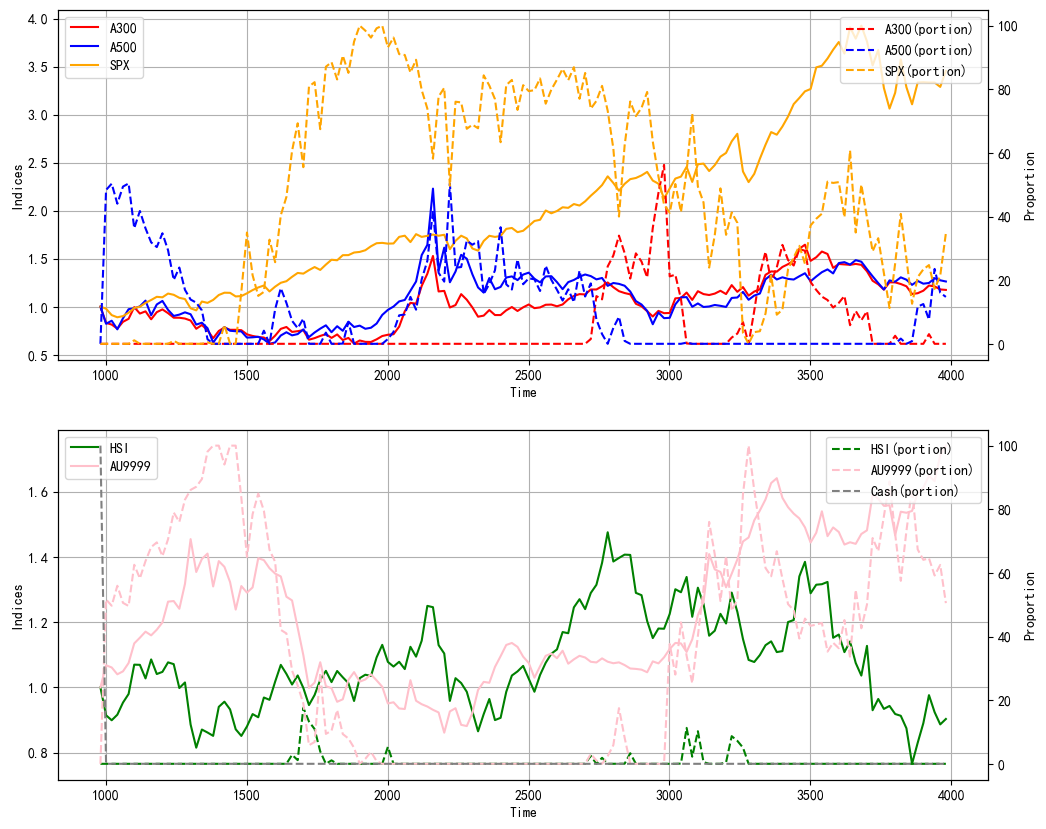

In [77]:
fig = plt.figure(figsize = (12,10))

time_series = np.arange(begin_time-adj_period, end_time+1,adj_period)
port_series = opt1_port
norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T
      
color = ['red', 'blue', 'orange', 'green', 'pink', 'grey']
    
ax = fig.add_subplot(211)
for i in range(3):
    ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
ax.set_xlabel('Time')
ax.set_ylabel('Indices')
ax.legend(loc = 'upper left')

ax.grid()

ax2 = ax.twinx()
for i in range(3):
    ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
ax2.set_ylabel('Proportion')
ax2.legend(loc = 'upper right')

ax = fig.add_subplot(212)
for i in range(3,n_ptf):
    ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
ax.set_xlabel('Time')
ax.set_ylabel('Indices')
ax.legend(loc = 'upper left')

ax2 = ax.twinx()
for i in range(3,n_ptf + 1):
    ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
ax2.set_ylabel('Proportion')
ax2.legend(loc = 'upper right')

ax.grid()

Start Date: 2010-05-12
End Date: 2023-05-11
Yearly Earning: 7.25%


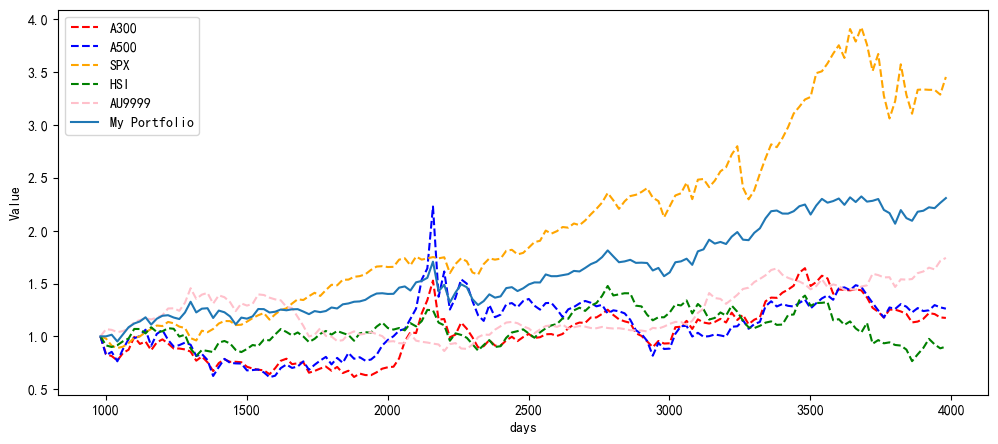

In [78]:
norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T

portfo = np.array([.0,.0,.0,.0,.0,1])
value_series = []
for time in range(begin_time - 20, end_time+1, adj_period):
    # 简单起见，不考虑手续费，先把所有东西卖了然后再买入
    prices_now = norm_prices[:,(time - (begin_time - adj_period))//adj_period]
    for i in range(n_ptf):
        portfo[n_ptf] += portfo[i] * prices_now[i]
        portfo[i] = .0
    ptf_portion = opt1_port.loc[:,time]
    value_series.append(portfo[n_ptf])
    
    for i in range(n_ptf):
        portfo[i] += portfo[n_ptf] * ptf_portion[i] *0.01 / prices_now[i]
    portfo[n_ptf] -= ptf_portion[:n_ptf].sum() * 0.01 * portfo[n_ptf]

fig = plt.figure(figsize=(12,5))
    
time_series = np.arange(begin_time-20, end_time+1,20)
plt.ticklabel_format(style='plain')
plt.xlabel('days')
plt.ylabel('Value')
for i in range(5):
    plt.plot(time_series, norm_prices[i,:], '--', label = names[i], color = color[i])
plt.plot(time_series, value_series, label='My Portfolio')
plt.legend()
print('Start Date:', str(SPX_VIX.loc[begin_time, 'DATE'])[:10])
print('End Date:', str(SPX_VIX.loc[end_time, 'DATE'])[:10])
print(f'Yearly Earning: {np.round((value_series[-1]**(1/((end_time-begin_time)/250)) - 1) * 100,2)}%')

### 直接把VIX指数放到MV优化器里

In [65]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([0,0,0,0,0,100.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - 20])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[time-1000:time], columns=names)
    R = R_df.values
    
    S = R.shape[0]
    stats_prior = ft.simulation_moments(R_df)
    maxRSI = np.max(RSIs[:,time-adj_period:time],axis=1)
    minRSI = np.min(RSIs[:,time-adj_period:time],axis=1)
    view_mean = np.zeros(n_ptf)
    for i in range(n_ptf):
        if maxRSI[i] >= 70:
            view_mean[i] -= 0.008
        if minRSI[i] <= 30:
            view_mean[i] += 0.005
    view_mean = stats_prior['Mean'] +view_mean
    
    p = (np.ones((S, 1),dtype=np.float64) / S)    # Prior distribution
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    b = np.append(np.array(1.0,dtype=np.float64), view_mean).reshape(-1,1)
    q1 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    view_mean = np.zeros(n_ptf)
    meanMTM = np.average(MTMs[:,time-adj_period:time], axis=1,weights = np.arange(1,2,0.05))
    for i in range(n_ptf):
        if 0.2 > meanMTM[i] > 0.1:
            view_mean += 0.004
        elif -0.2< meanMTM[i] < -0.1:
            view_mean -= 0.006
    view_mean = stats_prior['Mean'] +view_mean
    
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    b = np.append(np.array(1.0,dtype=np.float64), view_mean).reshape(-1,1)
    q2 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    q = q1 * 0.5 + q2 * 0.5
    q /= q.sum() # 缩放一下因为误差导致概率和不为1
    
    sim_end_time = 20
    sim_series = price_MonteCarlo(20000, n_ptf, R,q)
    sim_last = np.c_[sim_series,np.power((np.ones(sim_series.shape[0]) / (1+risk_free)), sim_end_time/250).reshape(-1,1)]
    sim_mean = np.power(np.mean(sim_last, axis=0), 250/sim_end_time) - 1
    sim_cov = np.cov(sim_last.T) * 250 / sim_end_time
    
    SPX_IV = SPX_VIX.loc[time, 'CLOSE']*0.01
    vol_scale = SPX_IV / np.sqrt(sim_cov[2,2])
    sim_cov[:,2] *= vol_scale
    sim_cov[2,:] *= vol_scale
    
    
#     try:
#         opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
#         _opt1_port = np.array(list(opt1.efficient_return(0.07).values())) * 100
#     except:
    if sim_mean.max() < risk_free:
        _opt1_port = pd.DataFrame([.0,.0,.0,.0,.0,100.], index = [*names, 'Cash'], columns = [time])
    else:
        opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
        _opt1_port = np.array(list(opt1.max_sharpe(risk_free_rate=risk_free).values()))  * 100
        _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)
    opt1.portfolio_performance(verbose=True)

1001
Expected annual return: 38.5%
Annual volatility: 23.8%
Sharpe Ratio: 1.54
1021
Expected annual return: 37.6%
Annual volatility: 24.4%
Sharpe Ratio: 1.46
1041
Expected annual return: 35.2%
Annual volatility: 24.2%
Sharpe Ratio: 1.37
1061
Expected annual return: 34.2%
Annual volatility: 24.9%
Sharpe Ratio: 1.29
1081
Expected annual return: 31.4%
Annual volatility: 24.9%
Sharpe Ratio: 1.18
1101
Expected annual return: 29.7%
Annual volatility: 20.5%
Sharpe Ratio: 1.35
1121
Expected annual return: 27.6%
Annual volatility: 21.6%
Sharpe Ratio: 1.18
1141
Expected annual return: 33.1%
Annual volatility: 22.5%
Sharpe Ratio: 1.39
1161
Expected annual return: 27.3%
Annual volatility: 20.0%
Sharpe Ratio: 1.26
1181
Expected annual return: 27.9%
Annual volatility: 19.8%
Sharpe Ratio: 1.31
1201
Expected annual return: 29.0%
Annual volatility: 20.4%
Sharpe Ratio: 1.32
1221
Expected annual return: 24.6%
Annual volatility: 18.9%
Sharpe Ratio: 1.20
1241
Expected annual return: 21.5%
Annual volatility

Expected annual return: 6.5%
Annual volatility: 12.2%
Sharpe Ratio: 0.37
3101
Expected annual return: 7.7%
Annual volatility: 8.4%
Sharpe Ratio: 0.69
3121
Expected annual return: 9.1%
Annual volatility: 9.0%
Sharpe Ratio: 0.79
3141
Expected annual return: 10.2%
Annual volatility: 9.8%
Sharpe Ratio: 0.83
3161
Expected annual return: 9.2%
Annual volatility: 9.5%
Sharpe Ratio: 0.76
3181
Expected annual return: 10.0%
Annual volatility: 8.4%
Sharpe Ratio: 0.95
3201
Expected annual return: 10.3%
Annual volatility: 8.7%
Sharpe Ratio: 0.95
3221
Expected annual return: 10.9%
Annual volatility: 7.9%
Sharpe Ratio: 1.13
3241
Expected annual return: 10.2%
Annual volatility: 8.1%
Sharpe Ratio: 1.01
3261
Expected annual return: 11.1%
Annual volatility: 9.3%
Sharpe Ratio: 0.98
3281
Expected annual return: 11.4%
Annual volatility: 10.2%
Sharpe Ratio: 0.92
3301
Expected annual return: 11.8%
Annual volatility: 9.6%
Sharpe Ratio: 1.01
3321
Expected annual return: 11.8%
Annual volatility: 9.7%
Sharpe Ratio

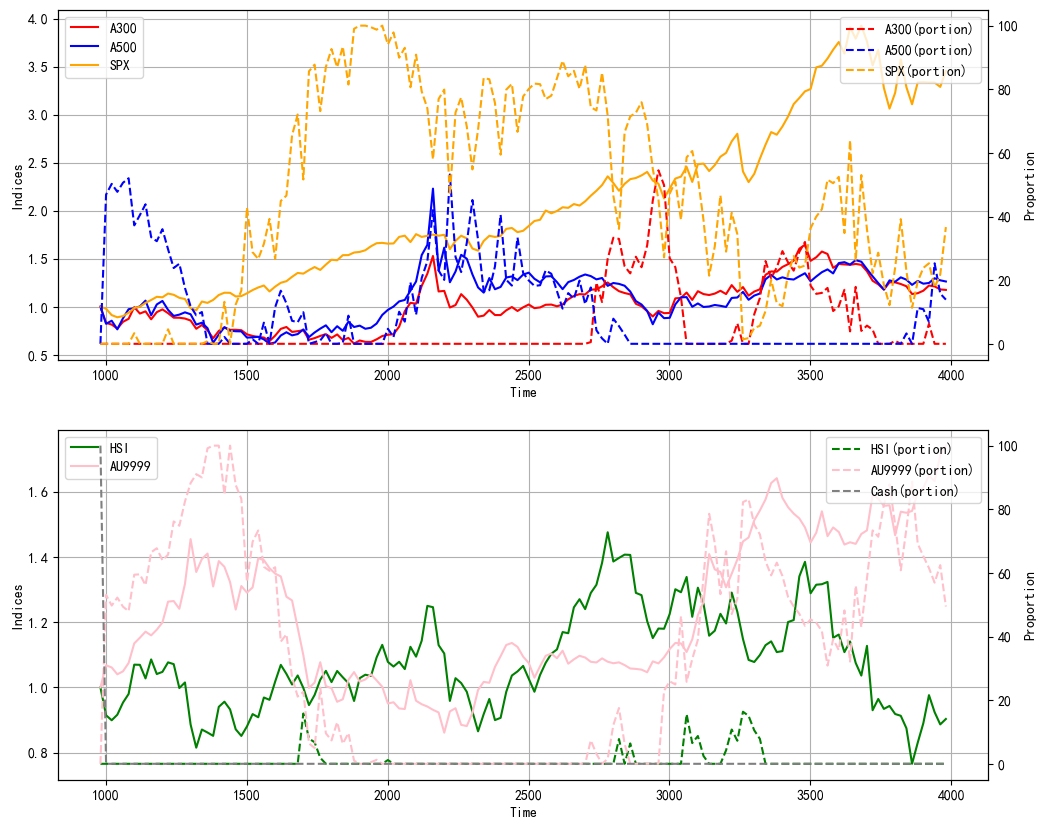

In [66]:
fig = plt.figure(figsize = (12,10))

time_series = np.arange(begin_time-adj_period, end_time+1,adj_period)
port_series = opt1_port
norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T
      
color = ['red', 'blue', 'orange', 'green', 'pink', 'grey']
    
ax = fig.add_subplot(211)
for i in range(3):
    ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
ax.set_xlabel('Time')
ax.set_ylabel('Indices')
ax.legend(loc = 'upper left')

ax.grid()

ax2 = ax.twinx()
for i in range(3):
    ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
ax2.set_ylabel('Proportion')
ax2.legend(loc = 'upper right')

ax = fig.add_subplot(212)
for i in range(3,n_ptf):
    ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
ax.set_xlabel('Time')
ax.set_ylabel('Indices')
ax.legend(loc = 'upper left')

ax2 = ax.twinx()
for i in range(3,n_ptf + 1):
    ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
ax2.set_ylabel('Proportion')
ax2.legend(loc = 'upper right')

ax.grid()

Start Date: 2006-01-01
End Date: 2023-06-01
Yearly Earning: 7.13%


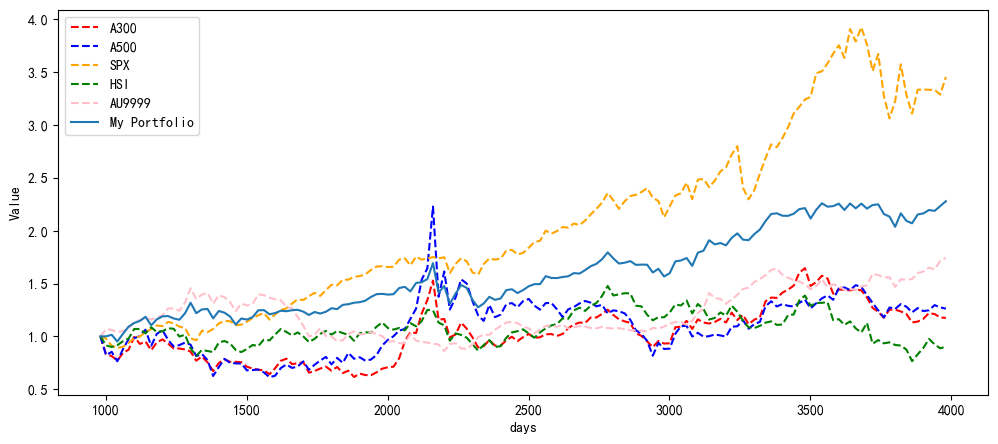

In [67]:
norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T

portfo = np.array([.0,.0,.0,.0,.0,1])
value_series = []
for time in range(begin_time - 20, end_time+1, adj_period):
    # 简单起见，不考虑手续费，先把所有东西卖了然后再买入
    prices_now = norm_prices[:,(time - (begin_time - adj_period))//adj_period]
    for i in range(n_ptf):
        portfo[n_ptf] += portfo[i] * prices_now[i]
        portfo[i] = .0
    ptf_portion = opt1_port.loc[:,time]
    value_series.append(portfo[n_ptf])
    
    for i in range(n_ptf):
        portfo[i] += portfo[n_ptf] * ptf_portion[i] *0.01 / prices_now[i]
    portfo[n_ptf] -= ptf_portion[:n_ptf].sum() * 0.01 * portfo[n_ptf]

fig = plt.figure(figsize=(12,5))
    
time_series = np.arange(begin_time-20, end_time+1,20)
plt.ticklabel_format(style='plain')
plt.xlabel('days')
plt.ylabel('Value')
for i in range(5):
    plt.plot(time_series, norm_prices[i,:], '--', label = names[i], color = color[i])
plt.plot(time_series, value_series, label='My Portfolio')
plt.legend()
print('Start Date:', start_date)
print('End Date:', end_date)
print(f'Yearly Earning: {np.round((value_series[-1]**(1/((end_time-begin_time)/250)) - 1) * 100,2)}%')

### 无RSI无EP纯Monte Carlo情况

In [389]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([0,0,0,0,0,100.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - 20])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[:time], columns=names)
    R = R_df.values
    S = R.shape[0]
    
    p = np.ones((S, 1),dtype=np.float64) / S    # Prior distribution
    
    sim_end_time = 20
    sim_series = price_MonteCarlo(20000, n_ptf,R, p)
    sim_last = np.c_[sim_series,np.power((np.ones(sim_series.shape[0]) / (1+risk_free)), sim_end_time/250).reshape(-1,1)]
    sim_mean = np.power(np.mean(sim_last, axis=0), 250/sim_end_time) - 1
    sim_cov = np.cov(sim_last.T) * 250 / sim_end_time
    
    if sim_mean.max() < risk_free:
        _opt1_port = pd.DataFrame([.0,.0,.0,.0,.0,100.], index = [*names, 'Cash'], columns = [time])
    else:
        opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
        _opt1_port = np.array(list(opt1.max_sharpe(risk_free_rate=risk_free).values()))  * 100
        _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)
    opt1.portfolio_performance(verbose=True)

1001
Expected annual return: 15.4%
Annual volatility: 21.0%
Sharpe Ratio: 0.64
1021
Expected annual return: 15.0%
Annual volatility: 21.4%
Sharpe Ratio: 0.61
1041
Expected annual return: 14.2%
Annual volatility: 21.5%
Sharpe Ratio: 0.57
1061
Expected annual return: 14.6%
Annual volatility: 20.4%
Sharpe Ratio: 0.62
1081
Expected annual return: 16.6%
Annual volatility: 20.9%
Sharpe Ratio: 0.70
1101
Expected annual return: 16.2%
Annual volatility: 19.7%
Sharpe Ratio: 0.72
1121
Expected annual return: 15.6%
Annual volatility: 20.6%
Sharpe Ratio: 0.66
1141
Expected annual return: 14.6%
Annual volatility: 20.1%
Sharpe Ratio: 0.63
1161
Expected annual return: 13.5%
Annual volatility: 19.3%
Sharpe Ratio: 0.60
1181
Expected annual return: 13.4%
Annual volatility: 19.1%
Sharpe Ratio: 0.60
1201
Expected annual return: 10.7%
Annual volatility: 18.2%
Sharpe Ratio: 0.48
1221
Expected annual return: 8.7%
Annual volatility: 17.1%
Sharpe Ratio: 0.39
1241
Expected annual return: 8.1%
Annual volatility: 

Expected annual return: 9.0%
Annual volatility: 13.8%
Sharpe Ratio: 0.51
3121
Expected annual return: 8.4%
Annual volatility: 13.0%
Sharpe Ratio: 0.49
3141
Expected annual return: 9.5%
Annual volatility: 13.8%
Sharpe Ratio: 0.55
3161
Expected annual return: 9.4%
Annual volatility: 13.4%
Sharpe Ratio: 0.55
3181
Expected annual return: 9.5%
Annual volatility: 14.3%
Sharpe Ratio: 0.52
3201
Expected annual return: 9.3%
Annual volatility: 13.3%
Sharpe Ratio: 0.55
3221
Expected annual return: 9.0%
Annual volatility: 13.4%
Sharpe Ratio: 0.52
3241
Expected annual return: 9.1%
Annual volatility: 13.5%
Sharpe Ratio: 0.53
3261
Expected annual return: 8.2%
Annual volatility: 13.0%
Sharpe Ratio: 0.48
3281
Expected annual return: 8.8%
Annual volatility: 12.9%
Sharpe Ratio: 0.53
3301
Expected annual return: 8.2%
Annual volatility: 13.0%
Sharpe Ratio: 0.48
3321
Expected annual return: 8.9%
Annual volatility: 12.7%
Sharpe Ratio: 0.54
3341
Expected annual return: 7.6%
Annual volatility: 12.9%
Sharpe Rat

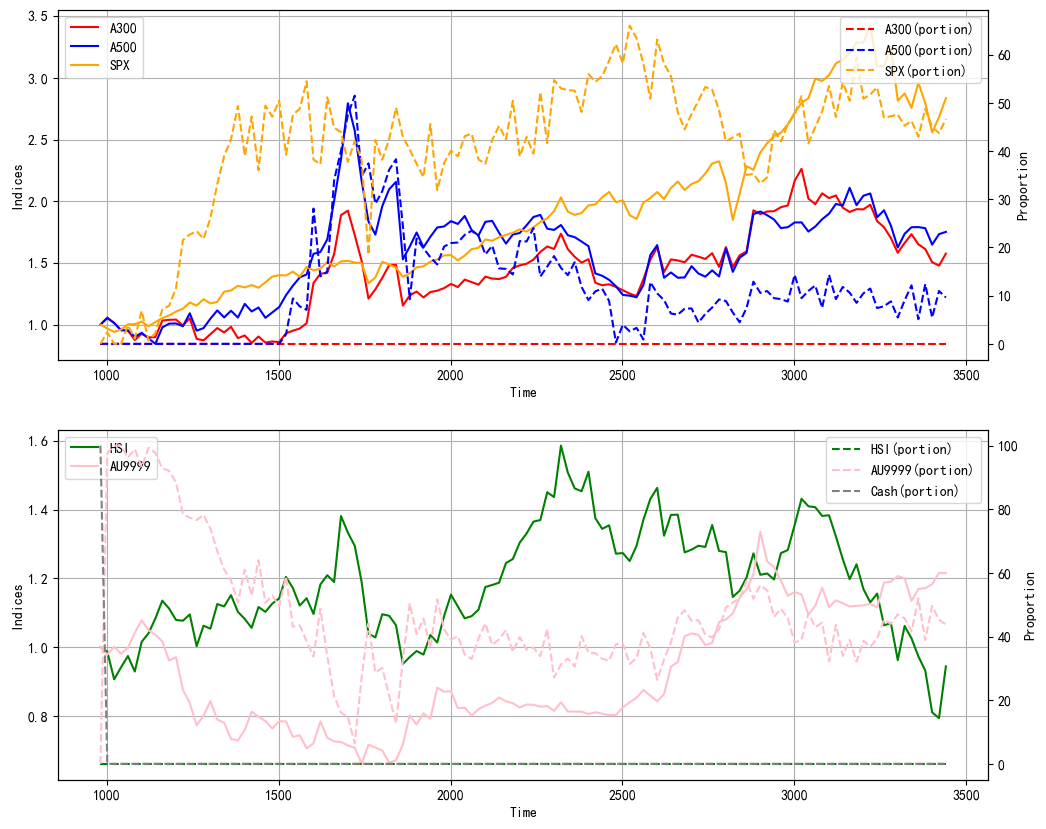

In [390]:
fig = plt.figure(figsize = (12,10))

time_series = np.arange(begin_time-adj_period, end_time+1,adj_period)
port_series = opt1_port
norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T
      
color = ['red', 'blue', 'orange', 'green', 'pink', 'grey']
    
ax = fig.add_subplot(211)
for i in range(3):
    ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
ax.set_xlabel('Time')
ax.set_ylabel('Indices')
ax.legend(loc = 'upper left')
ax.grid()

ax2 = ax.twinx()
for i in range(3):
    ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
ax2.set_ylabel('Proportion')
ax2.legend(loc = 'upper right')

ax = fig.add_subplot(212)
for i in range(3,n_ptf):
    ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
ax.set_xlabel('Time')
ax.set_ylabel('Indices')
ax.legend(loc = 'upper left')
ax.grid()

ax2 = ax.twinx()
for i in range(3,n_ptf + 1):
    ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
ax2.set_ylabel('Proportion')
ax2.legend(loc = 'upper right')

Yearly Earning: 3.26%


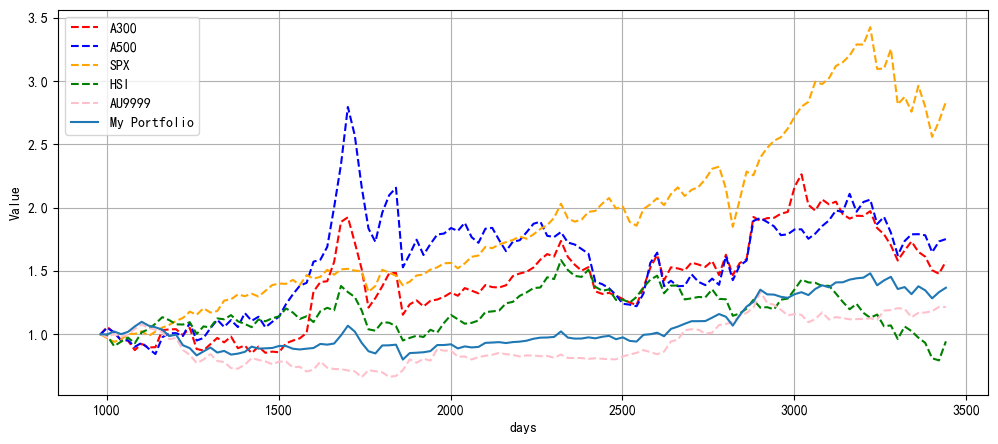

In [391]:
norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T

portfo = np.array([.0,.0,.0,.0,.0,1])
value_series = []
for time in range(begin_time - 20, end_time+1, adj_period):
    # 简单起见，不考虑手续费，先把所有东西卖了然后再买入
    prices_now = norm_prices[:,(time - (begin_time - adj_period))//adj_period]
    for i in range(n_ptf):
        portfo[n_ptf] += portfo[i] * prices_now[i]
        portfo[i] = .0
    ptf_portion = opt1_port.loc[:,time]
    value_series.append(portfo[n_ptf])
    
    for i in range(n_ptf):
        portfo[i] += portfo[n_ptf] * ptf_portion[i] *0.01 / prices_now[i]
    portfo[n_ptf] -= ptf_portion[:n_ptf].sum() * 0.01 * portfo[n_ptf]

fig = plt.figure(figsize=(12,5))
    
time_series = np.arange(begin_time-20, end_time+1,20)
plt.ticklabel_format(style='plain')
plt.xlabel('days')
plt.ylabel('Value')
for i in range(5):
    plt.plot(time_series, norm_prices[i,:], '--', label = names[i], color = color[i])
plt.plot(time_series, value_series, label='My Portfolio')
plt.legend()
plt.grid()
print(f'Yearly Earning: {np.round((value_series[-1]**(1/((end_time-begin_time)/250)) - 1) * 100,2)}%')

### 无Monte Carlo

In [392]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([0,0,0,0,0,100.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - 20])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[time - 1000:time], columns=names)
    R = R_df.values
    R = np.c_[R, np.ones(R.shape[0]) * np.power(1/(1+risk_free), 1/252) - 1]
    S = R.shape[0]
    
    p = np.ones((S, 1),dtype=np.float64) / S    # Prior distribution
    
    # 计算期望与协方差
    sim_mean = np.mean(R,axis = 0)
    sim_cov = np.cov(R.T)
    
    if sim_mean.max() < risk_free:
        _opt1_port = pd.DataFrame([.0,.0,.0,.0,.0,100.], index = [*names, 'Cash'], columns = [time])
    else:
        opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
        _opt1_port = np.array(list(opt1.max_sharpe(risk_free_rate=risk_free).values()))  * 100
        _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)
    opt1.portfolio_performance(verbose=True)

1001
Expected annual return: 6.2%
Annual volatility: 138.0%
Sharpe Ratio: 0.03
1021
Expected annual return: 5.4%
Annual volatility: 137.6%
Sharpe Ratio: 0.02
1041
Expected annual return: 4.6%
Annual volatility: 135.0%
Sharpe Ratio: 0.02
1061
Expected annual return: 5.7%
Annual volatility: 135.0%
Sharpe Ratio: 0.03
1081
Expected annual return: 6.4%
Annual volatility: 134.2%
Sharpe Ratio: 0.03
1101
Expected annual return: 6.9%
Annual volatility: 130.4%
Sharpe Ratio: 0.04
1121
Expected annual return: 5.8%
Annual volatility: 124.5%
Sharpe Ratio: 0.03
1141
Expected annual return: 6.4%
Annual volatility: 121.0%
Sharpe Ratio: 0.04
1161
Expected annual return: 7.2%
Annual volatility: 107.6%
Sharpe Ratio: 0.05
1181
Expected annual return: 7.3%
Annual volatility: 95.1%
Sharpe Ratio: 0.06
1201
Expected annual return: 7.4%
Annual volatility: 87.8%
Sharpe Ratio: 0.06
1221
Expected annual return: 6.2%
Annual volatility: 89.0%
Sharpe Ratio: 0.05
1241
Expected annual return: 6.7%
Annual volatility: 88

Expected annual return: 4.0%
Annual volatility: 75.1%
Sharpe Ratio: 0.03
3361
Expected annual return: 4.6%
Annual volatility: 77.1%
Sharpe Ratio: 0.03
3381
Expected annual return: 4.3%
Annual volatility: 75.4%
Sharpe Ratio: 0.03
3401
Expected annual return: 4.1%
Annual volatility: 74.1%
Sharpe Ratio: 0.03
3421
Expected annual return: 4.2%
Annual volatility: 70.1%
Sharpe Ratio: 0.03
3441
Expected annual return: 4.3%
Annual volatility: 70.2%
Sharpe Ratio: 0.03


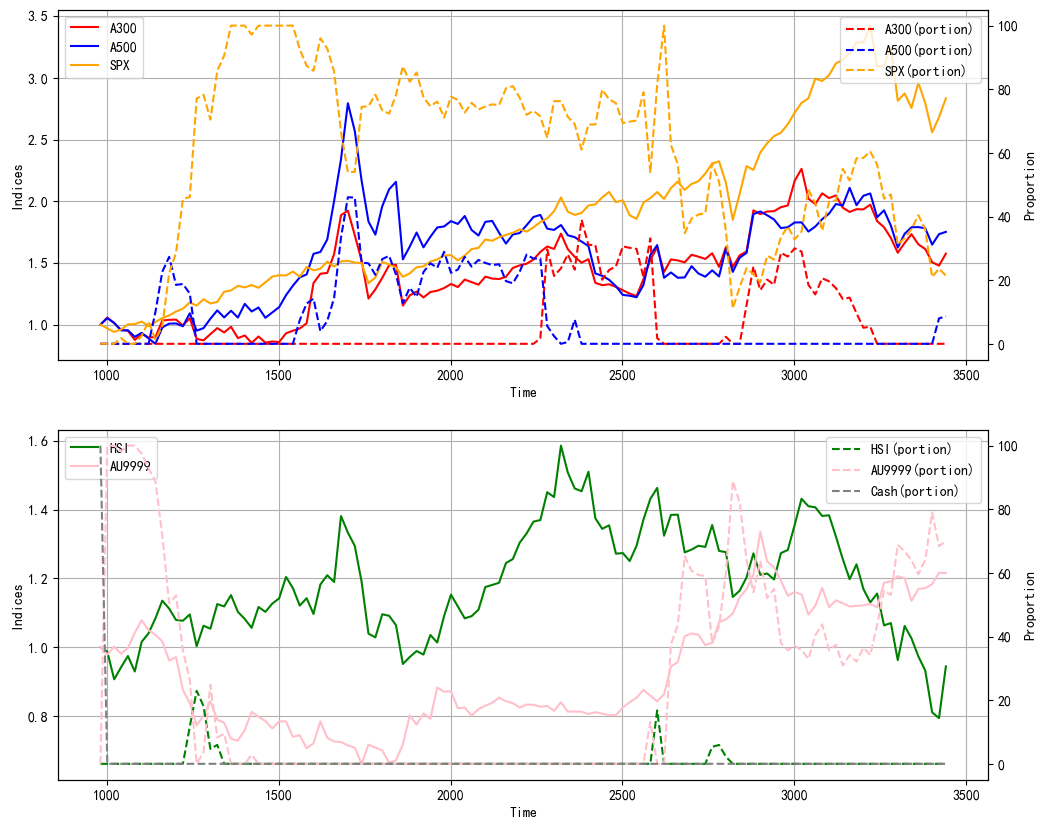

In [393]:
fig = plt.figure(figsize = (12,10))

time_series = np.arange(begin_time-adj_period, end_time+1,adj_period)
port_series = opt1_port
norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T
      
color = ['red', 'blue', 'orange', 'green', 'pink', 'grey']
    
ax = fig.add_subplot(211)
for i in range(3):
    ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
ax.set_xlabel('Time')
ax.set_ylabel('Indices')
ax.legend(loc = 'upper left')
ax.grid()

ax2 = ax.twinx()
for i in range(3):
    ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
ax2.set_ylabel('Proportion')
ax2.legend(loc = 'upper right')

ax = fig.add_subplot(212)
for i in range(3,n_ptf):
    ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
ax.set_xlabel('Time')
ax.set_ylabel('Indices')
ax.legend(loc = 'upper left')
ax.grid()

ax2 = ax.twinx()
for i in range(3,n_ptf + 1):
    ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
ax2.set_ylabel('Proportion')
ax2.legend(loc = 'upper right')

Yearly Earning: 6.13%


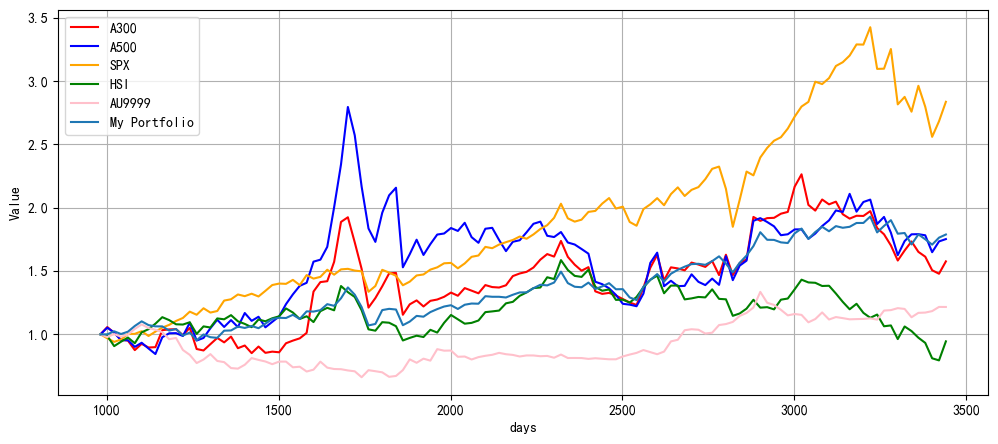

In [394]:
norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T

portfo = np.array([.0,.0,.0,.0,.0,1])
value_series = []
for time in range(begin_time - 20, end_time+1, adj_period):
    # 简单起见，不考虑手续费，先把所有东西卖了然后再买入
    prices_now = norm_prices[:,(time - (begin_time - adj_period))//adj_period]
    for i in range(n_ptf):
        portfo[n_ptf] += portfo[i] * prices_now[i]
        portfo[i] = .0
    ptf_portion = opt1_port.loc[:,time]
    value_series.append(portfo[n_ptf])
    
    for i in range(n_ptf):
        portfo[i] += portfo[n_ptf] * ptf_portion[i] *0.01 / prices_now[i]
    portfo[n_ptf] -= ptf_portion[:n_ptf].sum() * 0.01 * portfo[n_ptf]

fig = plt.figure(figsize=(12,5))
    
time_series = np.arange(begin_time-20, end_time+1,20)
plt.ticklabel_format(style='plain')
plt.xlabel('days')
plt.ylabel('Value')
for i in range(5):
    plt.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
plt.plot(time_series, value_series, label='My Portfolio')
plt.legend()
plt.grid()
print(f'Yearly Earning: {np.round((value_series[-1]**(1/((end_time-begin_time)/250)) - 1) * 100,2)}%')

## Ornstein-Ulenbeck过程

In [ ]:
def OU_MLE(time_series, dt, N):
    """
    Use Minimal Likelihood Estimation for OU process parameter
    """
    XX = time_series[:-1]
    YY = time_series[1:]
    
    Sx = np.sum(XX)
    Sy = np.sum(YY)
    Sxx = XX @ XX
    Sxy = XX @ YY
    Syy = YY @ YY

    mu_mle = (Sy*Sxx - Sx*Sxy) / (N*(Sxx-Sxy) - (Sx**2 - Sx*Sy) )
    theta_mle = -1/dt * np.log( (Sxy - mu_mle*Sx - mu_mle*Sy +N*mu_mle**2) 
                              / (Sxx - 2*mu_mle*Sx + N*mu_mle**2)  )
    sigma2_hat = ( Syy -2*np.exp(-theta_mle*dt)*Sxy + np.exp(-2*theta_mle*dt)*Sxx - 2*mu_mle*
                 (1-np.exp(-theta_mle*dt))*(Sy-np.exp(-theta_mle*dt)*Sx) + N*mu_mle**2 * 
                  (1-np.exp(-theta_mle*dt))**2 )/N
    sigma2_mle = sigma2_hat * 2*theta_mle / (1-np.exp(-2*theta_mle*dt))
    
    return mu_mle * theta_mle, theta_mle, sigma2_mle

In [ ]:
N = 500

Mu = []
Theta = []
Sigma2 = []

for i in range(prices.shape[0]):
    _mu, _theta, _sigma2  = OU_MLE(prices[i][:N], 1, N)
    Mu.append(_mu)
    Theta.append(_theta)
    Sigma2.append(_sigma2)
Mu = np.array(Mu)
Theta = np.diag(Theta)
# Estimated Sigma2
obv_sig2 = 2*np.dot(Theta,np.cov(prices[:,:N]))
print("Cov:\n", obv_sig2)
Sigma2 = obv_sig2- np.diag(np.diagonal(obv_sig2)) + np.diag(Sigma2)

print("Mu:", Mu)
print("Theta:\n", Theta)
print("Sigma2:\n",Sigma2)

In [ ]:
# Save data for MATLAB
scio.savemat('./Meucci/CalibratedParameters.mat',
             {'mu': Mu.reshape(-1,1), 'sig2': Sigma2,
            'theta': Theta, 'x0': prices[:,500]})
scio.savemat('./Meucci/path_daily.mat', {'A300_path': prices[0].reshape(-1,1), 'A500_path': prices[1].reshape(-1,1),
                                         'SPX_path': prices[2].reshape(-1,1), 'HSI_path': prices[3].reshape(-1,1), 'AU9999_path': prices[4].reshape(-1,1)})